## Support script to help match catalogs by ID. 

In [2]:
import numpy as np
import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
import pickle
plot_pretty()

# setup notebook for inline figures
%matplotlib inline

from tools.setup.setup import data_home_dir, home_dir, bigdata_home_dir
import astropy.io.fits as fits

datadir = data_home_dir()
homedir = home_dir()
bigdatadir = bigdata_home_dir()

### For this project match a halo ASCII file and a halo FITS file by ID and compare positions. 

### Reading the ASCII file and reducing to proper format. 
##### ID DESCID MVIR VMAX VRMS RVIR RS NP X Y Z VX VY VZ PID  (from Heidi)


In [57]:
from astropy.io import ascii
ascii_table = bigdatadir + 'Buzzard_Sims/v1.9.2/Chinchilla-4/cut_reform_out_0.parents'

f = open(ascii_table, 'r')
num_lines = sum(1 for line in open(ascii_table))-1 #Read number of (non-header) lines 
print "Number of non-header lines in file is ", num_lines

Number of non-header lines in file is  12473516


In [58]:
# Read and ignore header lines
header1 = f.readline()
print header1

# Loop over lines and extract variables of interest
data = []
ascii_data = np.recarray((num_lines,), dtype=[('ID', int), ('MVIR', float), ('RVIR', float), \
                                 ('X', float), ('Y', float), ('Z', float), ('PID', int)])
curline = 0
for line in f:
    line = line.strip()
    columns = line.split()
    ascii_data[curline]['ID'] = columns[0]
    ascii_data[curline]['MVIR'] = columns[2]
    ascii_data[curline]['RVIR'] = columns[5]
    ascii_data[curline]['X'] = columns[8]
    ascii_data[curline]['Y'] = columns[9]
    ascii_data[curline]['Z'] = columns[10]
    ascii_data[curline]['PID'] = columns[14]
    curline += 1
    if curline%1e6==0: print "Halo number ", curline
f.close()
print "Done with reading file"
print "Total number of halos in ASCII file is ", len(ascii_data)

# ID DESCID MVIR VMAX VRMS RVIR RS NP X Y Z VX VY VZ PID

Halo number  1000000
Halo number  2000000
Halo number  3000000
Halo number  4000000
Halo number  5000000
Halo number  6000000
Halo number  7000000
Halo number  8000000
Halo number  9000000
Halo number  10000000
Halo number  11000000
Halo number  12000000
Done with reading file
Total number of halos in ASCII file is  12473516


In [59]:
print ascii_data.dtype
print ascii_data[0]
print ascii_data[8]['MVIR']

(numpy.record, [('ID', '<i8'), ('MVIR', '<f8'), ('RVIR', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('PID', '<i8')])
(42007, 3.248e+12, 362.194, -2285.09277, 13.51221, 5.89136, -1)
7958000000000.0


### Import Chinchilla-4 halo fits file. 

In [54]:
halos_dir = bigdatadir + 'Buzzard_Sims/v1.9.2/Chinchilla-4/halos/Chinchilla-4_halos.all.fits'
halos_list = fits.open(halos_dir)
halos_data = halos_list[1].data

#Checking FITS into
#hrun_list.info()
print "Names of columns in halos_data are: \n"
print halos_data.names

#Converting FITS files into record array
halos_data = np.array(halos_data, dtype=halos_data.dtype)
halos_data = halos_data.view(np.recarray)

print "\n Number of halos is", len(halos_data.ID)

Names of columns in halos_data are: 

['A[Z]', 'A[Y]', 'RA', 'C[Y]', 'VMAX', 'C_TO_A', 'Z', 'Z_COS', 'JX', 'B[Z]', 'TRA', 'VZ', 'B[X]', 'VY', 'HOST_HALOID', 'M200C', 'B[Y]', 'VX', 'JZ', 'A[X]', 'VRMS', 'M200B', 'M500C', 'TDEC', 'RS', 'C[Z]', 'ID', 'SPIN', 'VOFF', 'NP', 'PY', 'RVIR', 'M2500C', 'DEC', 'MVIR', 'C[X]', 'PZ', 'JY', 'XOFF', 'PX', 'B_TO_A']

 Number of halos is 13368118


### Sort catalogs by ID and compare PX, PY, PZ

#### Clean up repeating halos

In [55]:
##Cut out non-parent halos
print "Before cut number of halos is ", len(halos_data)
hostcut = np.where(halos_data['HOST_HALOID'] == -1)
halos_data = halos_data[hostcut]
print "After cutting out non-host halos number of halos in halos_data is ", len(halos_data) 

#Halo catalog has repeating halos. Clean that up
unique_ID, unique_ind = np.unique(halos_data['ID'], return_index=True)
halos_data = halos_data[unique_ind]
print "After unique cut number of halos is ", len(halos_data)



Before cut number of halos is  13368118
After cutting out non-host halos number of halos in halos_data is  12769538
After unique cut number of halos is  12279575


In [56]:
#ASCII catalog has repeating halos. Clean that up
print "Before unique cut number of halos is ", len(ascii_data)
unique_ID, unique_ind = np.unique(ascii_data['ID'], return_index=True)
ascii_data = ascii_data[unique_ind]
print "After unique cut number of halos is ", len(ascii_data)

Before unique cut number of halos is  5872710
After unique cut number of halos is  5872710


#### Matching by ID

In [64]:
## Filter the halo catalog with IDs matching ASCII
print "Number of halos in halos_data is ", len(halos_data)
halos_matched_bool = np.isin(halos_data['ID'], ascii_data['ID'])
halocut = np.where(halos_matched_bool == True)[0]
halos_data = halos_data[halocut]
print "After halocut number of halos in halos_data is ", len(halos_data)

Number of halos in halos_data is  5691308
After halocut number of halos in halos_data is  5691308


In [65]:
## Filter the halo catalog with IDs matching ASCII
print "Number of halos in ASCII is ", len(ascii_data)
halos_matched_bool = np.isin(ascii_data['ID'], halos_data['ID'])
halocut = np.where(halos_matched_bool == True)[0]
ascii_data = ascii_data[halocut]
print "After halocut number of halos in ASCII is ", len(ascii_data)

Number of halos in ASCII is  5691308
After halocut number of halos in ASCII is  5691308


In [66]:
#Check that all IDs are one-to-one matched
ID_matched_bool = np.isin(halos_data['ID'], ascii_data['ID'])
ID_matched_num = len(ID_matched_bool)
print "After halocut ", ID_matched_num, " out of ", len(halos_data), "halos in halos_data are in ASCII"

ID_matched_bool = np.isin(ascii_data['ID'], halos_data['ID'])
ID_matched_num = len(ID_matched_bool)
print "After halocut ", ID_matched_num, " out of ", len(ascii_data), "halos in ascii_data are in halos_data"

After halocut  5691308  out of  5691308 halos in halos_data are in ASCII
After halocut  5691308  out of  5691308 halos in ascii_data are in halos_data


#### Sort catalogs by ID

In [67]:
#Sort the arrays by order of ID. That way the indices match. 
#For ASCII
ID_sort = np.argsort(ascii_data['ID'])
ascii_data = ascii_data[ID_sort]
print "After sorting, IDs in ASCII are: "
print ascii_data['ID'], "\n"

#For redM_halos
ID_sort = np.argsort(halos_data['ID'])
halos_data = halos_data[ID_sort]
print "After sorting, IDs in halos_data are: "
print halos_data['ID'], "\n"

print np.where(np.isin(halos_data['ID'], ascii_data['ID']) == False)
print np.where(np.isin(ascii_data['ID'], halos_data['ID'], ) == False)

After sorting, IDs in ASCII are: 
[       1        5       11 ... 40602837 40606718 40608601] 

After sorting, IDs in halos+data are: 
[       1        5       11 ... 40602837 40606718 40608601] 

(array([], dtype=int64),)
(array([], dtype=int64),)


### Comparing properties of ID-matched catalogs

In [78]:
x_diff = (halos_data['PX'] - ascii_data['X'])[::1000]
y_diff = (halos_data['PY'] - ascii_data['Y'])[::1000]
z_diff = (halos_data['PZ'] - ascii_data['Z'])[::1000]

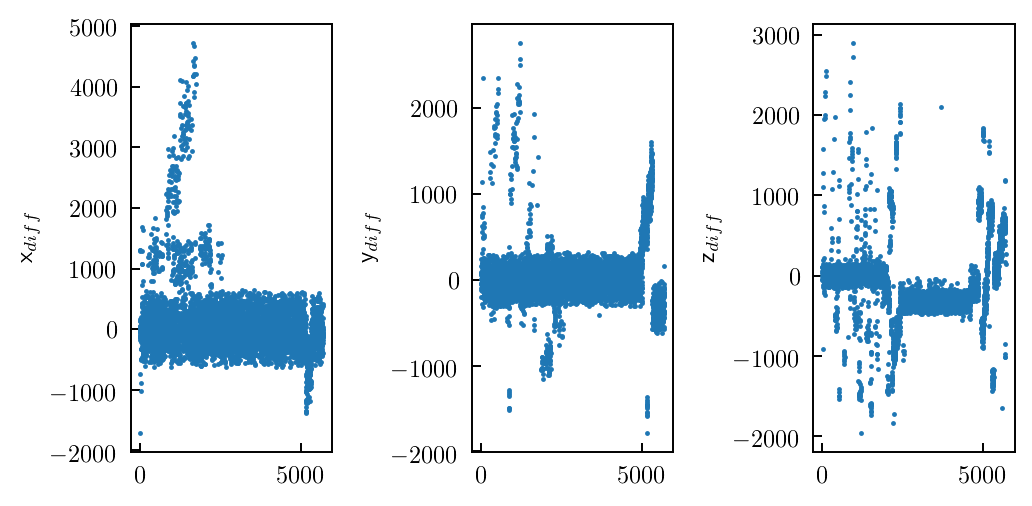

In [102]:
#Plotting coordinate differences
fig, ax = plt.subplots(1,3, figsize=(6,3))
ax[0].plot(x_diff, 'o', markersize=1)
ax[0].set_ylabel(r'x$_{diff}$')
ax[1].plot(y_diff, 'o', markersize=1)
ax[1].set_ylabel(r'y$_{diff}$')
ax[2].plot(z_diff, 'o', markersize=1)
ax[2].set_ylabel(r'z$_{diff}$')
fig.tight_layout()
plt.show()

In [80]:
#Plotting Mvir, Rvir differences
m_diff = (halos_data['MVIR'] - ascii_data['MVIR'])[::1000]
rvir_diff = (halos_data['RVIR'] - ascii_data['RVIR'])[::1000]

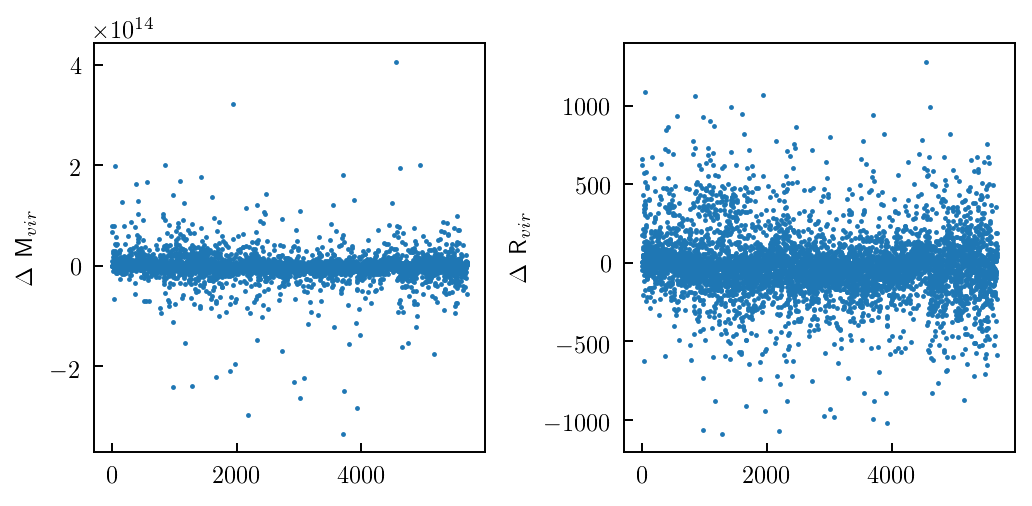

In [98]:
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].plot(m_diff, 'o', markersize=1)
ax[0].set_ylabel(r'$\Delta$~M$_{vir}$')
ax[1].plot(rvir_diff, 'o', markersize=1)
ax[1].set_ylabel(r'$\Delta$~R$_{vir}$')
fig.tight_layout()
plt.show()